## Data Augmentation

### Check GPU Type

In [ ]:
!nvidia-smi

Sun Dec  3 00:39:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.24       Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  Off |
| 37%   60C    P2   328W / 450W |  23918MiB / 24564MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import Packages

In [ ]:
_exp_name = "NoduleMask"

In [ ]:
# Import necessary packages.
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset
# This is for the progress bar.
from tqdm.auto import tqdm
import random
from random import shuffle

# cache
from functools import lru_cache

In [ ]:
myseed = 6666  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
#This flag allows you to enable the inbuilt cudnn auto-tuner to find the best algorithm to use for your hardware.
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

### Datasets

In [ ]:
class DADataset(Dataset):
    def __init__(self, path, part, files=None):
        super(DADataset, self).__init__()
        self.path = path
        self.files = sorted([os.path.join(path, x) for x in os.listdir(path)])
        random.seed(8)  # Use random.seed to ensure reproducibility
        random.shuffle(self.files)
        total_files = len(self.files)
        cutTrain = total_files // 10 * 8
        cutTest = int(len(self.files) // 10 * 9)
        if part == "train":
            self.files = self.files[:cutTrain]
        elif part == "val":
            self.files = self.files[cutTrain:cutTest]
        elif part == "test":
            self.files = self.files[cutTest:]
        else:
            raise ValueError("Invalid part. Must be 'train', 'val', or 'test'.")
        if files is not None:
            self.files = files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]

        # Split the string using the underscore as a delimiter
        pid = fname.split("\\")[-1].split("_")[-2]
        slice_num = int(fname.split("\\")[-1].split("_")[-1])
        im = torch.from_numpy(np.load(fname + "/train_mask.npy")).float()
        label = torch.from_numpy(np.load(fname + "/val_mask.npy")).float()
        # print(label)

        return pid, slice_num, im, label

### Model

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.down_conv1 = self.double_conv(4, 64)
        self.down_conv2 = self.double_conv(64, 128)
        self.down_conv3 = self.double_conv(128, 256)
        self.down_conv4 = self.double_conv(256, 512)
        self.up_conv1 = self.double_conv(512 + 256, 256)
        self.up_conv2 = self.double_conv(256 + 128, 128)
        self.up_conv3 = self.double_conv(128 + 64, 64)
        self.up_conv4 = nn.Conv2d(64, 1, kernel_size=1)
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Downward path
        x1 = self.down_conv1(x)
        x2 = self.maxpool(x1)
        x3 = self.down_conv2(x2)
        x4 = self.maxpool(x3)
        x5 = self.down_conv3(x4)
        x6 = self.maxpool(x5)
        x7 = self.down_conv4(x6)

        # Upward path
        x = self.upsample(x7)
        x = torch.cat([x, x5], dim=1)
        x = self.up_conv1(x)
        x = self.upsample(x)
        x = torch.cat([x, x3], dim=1)
        x = self.up_conv2(x)
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up_conv3(x)
        x = self.up_conv4(x)

        return x

### Configurations

In [ ]:
# "cuda" only when GPUs are available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize a model and put it on the specified device.
model = UNet().to(device)

# The number of batch size.
batch_size = 10

### Dataloader for test

In [ ]:
test_set =  DADataset("../Luna16_data/split4_mask_data_nodule", "test")
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

### Testing (ignore)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
model_best = UNet().to(device)
model_best.load_state_dict(torch.load(f"{_exp_name}_best.ckpt"))
model_best.eval()

# Initialize variables to store evaluation metrics
mask_mae_total = 0.0
mask_mse_total = 0.0
mask_iou_total = 0.0
mask_dice_total = 0.0
num_samples = 0

with torch.no_grad():
    for pid, slice_num, data, truth in tqdm(test_loader):
        test_pred = model_best(data.to(device))

        mask_testpred = test_pred.cpu()
        mask_truth = truth.cpu().numpy()

        threshold = 0.5  # You can adjust this threshold as needed
        mask_testpred = (test_pred.cpu() >= threshold).to(torch.int).numpy()

        # Calculate Mean Absolute Error (MAE)
        # mae = np.abs(HU_testpred - HU_truth).mean()
        mae_mask = np.abs(mask_testpred - mask_truth).mean()
        # mae_total += mae
        mask_mae_total += mae_mask

        # Calculate Mean Squared Error (MSE)
        mse_mask = ((mask_testpred - mask_truth) ** 2).mean()
        mask_mse_total += mse_mask

        # IoU
        intersection_mask = np.logical_and(mask_testpred > 0, mask_truth > 0)
        union_mask = np.logical_or(mask_testpred > 0, mask_truth > 0)
        iou_mask = np.sum(intersection_mask) / np.sum(union_mask)
        mask_iou_total += iou_mask

        # dice Coeff
        dice_mask = (2.0 * np.sum(intersection_mask)) / (np.sum(mask_testpred > 0) + np.sum(mask_truth > 0))
        mask_dice_total += dice_mask

        num_samples += 1

mask_average_mae = mask_mae_total / num_samples
mask_average_mse = mask_mse_total / num_samples
mask_average_iou = mask_iou_total / num_samples
mask_average_dice = mask_dice_total / num_samples

print()
print("masked data")
print(f"Average MAE: {mask_average_mae}")
print(f"Average MSE: {mask_average_mse}")
print(f"Average IoU: {mask_average_iou}")
print(f"Average Dice Coefficient: {mask_average_dice}")

  0%|          | 0/85 [00:00<?, ?it/s]


masked data
Average MAE: 0.0013238943324369549
Average MSE: 0.0013238943324369549
Average IoU: 0.04851241522283659
Average Dice Coefficient: 0.9217631140554421


Mean Absolute Error (MAE):

MAE measures the absolute difference between the predicted and ground truth values on a per-pixel/voxel basis.
A lower MAE indicates better accuracy.
Benchmark: MAE values typically range from 0 to a few units (e.g., 0 to 5 HU for CT images).

Mean Squared Error (MSE):
MSE measures the squared difference between predicted and ground truth values on a per-pixel/voxel basis.
A lower MSE indicates better accuracy.
Benchmark: MSE values typically range from 0 to a few tens (e.g., 0 to 100) for HU values.

Intersection over Union (IoU):
IoU measures the overlap between the predicted and ground truth binary masks.
It ranges from 0 (no overlap) to 1 (perfect overlap).
Benchmark: IoU values above 0.7 are generally considered good for medical image segmentation.

Dice Coefficient:
The Dice Coefficient also measures the overlap between the predicted and ground truth binary masks.
It ranges from 0 (no overlap) to 1 (perfect overlap).
Benchmark: Dice values above 0.7 are considered good for medical image segmentation.

## Get Predict

In [ ]:
model_best = UNet().to(device)
model_best.load_state_dict(torch.load(f"{_exp_name}_best.ckpt"))
model_best.eval()

count = 0
with torch.no_grad():
    for pid, slice_num, data, truth in tqdm(test_loader):
        test_pred = model_best(data.to(device))
        print(pid, slice_num)

        threshold = 0.5  # You can adjust this threshold as needed
        mask_testpred = (test_pred.cpu() >= threshold).to(torch.int).numpy()

        np.save('mask_pred.npy', mask_testpred)
        np.save('mask_truth.npy', truth.cpu().numpy())

        count += 1

        if count == 1:
            break

  0%|          | 0/85 [00:00<?, ?it/s]

['1.3.6.1.4.1.14519.5.2.1.6279.6001.779493719385047675154892222907', '1.3.6.1.4.1.14519.5.2.1.6279.6001.332829333783605240302521201463', '1.3.6.1.4.1.14519.5.2.1.6279.6001.316900421002460665752357657094', '1.3.6.1.4.1.14519.5.2.1.6279.6001.946129570505893110165820050204', '1.3.6.1.4.1.14519.5.2.1.6279.6001.187694838527128312070807533473', '1.3.6.1.4.1.14519.5.2.1.6279.6001.153985109349433321657655488650', '1.3.6.1.4.1.14519.5.2.1.6279.6001.257383535269991165447822992959', '1.3.6.1.4.1.14519.5.2.1.6279.6001.771741891125176943862272696845', '1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441', '1.3.6.1.4.1.14519.5.2.1.6279.6001.275755514659958628040305922764'] tensor([ 94, 120, 104, 159, 141, 258,  93, 134, 157, 227])


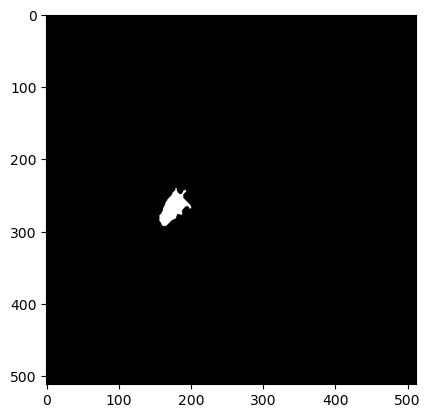

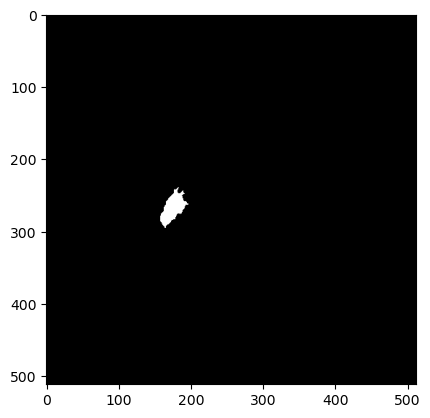

In [ ]:
mask_loaded_pred_array = np.load('mask_pred.npy').reshape((-1, 512, 512))
plt.imshow(mask_loaded_pred_array[5], cmap = 'gray', vmin=0, vmax=1)
plt.show()

mask_loaded_truth_array = np.load('mask_truth.npy').reshape((-1, 512, 512))
plt.imshow(mask_loaded_truth_array[5], cmap = 'gray', vmin=0, vmax=1)
plt.show()

subset0
subset1
subset2
subset3
subset4
subset5
subset6
subset7
subset8
subset9
[[-3024 -3024 -3024 ... -3024 -3024 -3024]
 [-3024 -3024 -3024 ... -3024 -3024 -3024]
 [-3024 -3024 -3024 ... -3024 -3024 -3024]
 ...
 [-3024 -3024 -3024 ... -3024 -3024 -3024]
 [-3024 -3024 -3024 ... -3024 -3024 -3024]
 [-3024 -3024 -3024 ... -3024 -3024 -3024]]


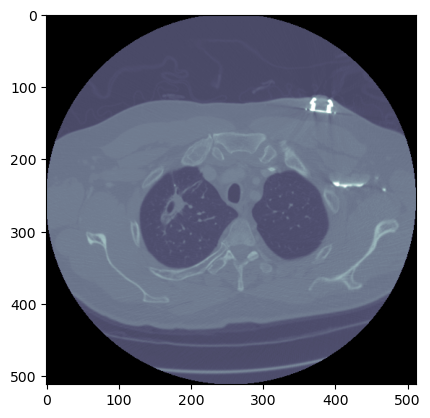

In [ ]:
import SimpleITK as sitk
read_root = "../Luna16_data/Luna16_img"
sub_directories = os.listdir(read_root)

for sub_dir in sub_directories:
    print(sub_dir)
    sub_dir_path = os.path.join(read_root, sub_dir)
    for file_name in os.listdir(sub_dir_path):
        if file_name.endswith(".mhd"):
            if file_name[:-4] == "1.3.6.1.4.1.14519.5.2.1.6279.6001.153985109349433321657655488650":
                file_path = os.path.join(sub_dir_path, file_name)
                data = sitk.ReadImage(file_path)
                ct_scan = sitk.GetArrayFromImage(data)
                print(ct_scan[258])
                plt.imshow(ct_scan[258], cmap = 'bone')
                plt.show()

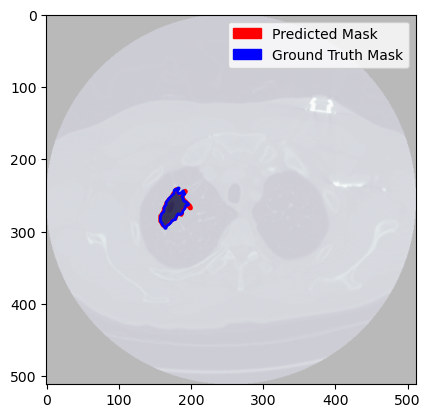

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import matplotlib.patches as mpatches
import os

# Load CT scan
read_root = "../Luna16_data/Luna16_img"
sub_directories = os.listdir(read_root)

last_ct_scan = None

for sub_dir in sub_directories:
    sub_dir_path = os.path.join(read_root, sub_dir)
    for file_name in os.listdir(sub_dir_path):
        if file_name.endswith(".mhd"):
            if file_name[:-4] == "1.3.6.1.4.1.14519.5.2.1.6279.6001.153985109349433321657655488650":
                file_path = os.path.join(sub_dir_path, file_name)
                data = sitk.ReadImage(file_path)
                last_ct_scan = sitk.GetArrayFromImage(data)

# Load mask arrays
mask_loaded_pred_array = np.load('mask_pred.npy').reshape((-1, 512, 512))
mask_loaded_truth_array = np.load('mask_truth.npy').reshape((-1, 512, 512))

# Overlay masks on the last CT scan slice
plt.imshow(last_ct_scan[258], cmap='bone')

# Overlay predicted mask in red with transparency
plt.imshow(mask_loaded_pred_array[5], cmap='Reds', alpha=0.5, vmin=0, vmax=1)

# Overlay ground truth mask in blue with transparency
plt.imshow(mask_loaded_truth_array[5], cmap='Blues', alpha=0.5, vmin=0, vmax=1)

# Draw clear boundary between masks
contour_pred = plt.contour(mask_loaded_pred_array[5], levels=[0.5], colors='red', linewidths=2)
contour_truth = plt.contour(mask_loaded_truth_array[5], levels=[0.5], colors='blue', linewidths=2)

# Create legend
legend_pred = mpatches.Patch(color='red', label='Predicted Mask')
legend_truth = mpatches.Patch(color='blue', label='Ground Truth Mask')
plt.legend(handles=[legend_pred, legend_truth])

# Show the plot
plt.show()